In [14]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
# import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random


import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb

# nltk.download('wordnet')

In [15]:
MAX_LENGTH = 1024
BASE_PATH = "/root/autodl-tmp/socre/"
TEST_DATA_PATH = "test.csv"
# MODEL_PATH = '/kaggle/input/aes-deberta-large/*/*'
EVAL_BATCH_SIZE = 1

# DATA LOADER

In [16]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = BASE_PATH

train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


# PREPROCESSING

In [4]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

## Paragraph feature

* 预处理：首先，通过 Paragraph_Preprocess 函数对原始文本数据进行预处理。这包括将包含段落的列表或数组的列拆分成多行，然后对每个段落进行预处理，例如清理文本、分词等，最后计算每个段落的长度、句子数量和单词数量。
* 特征提取：接下来，通过 Paragraph_Eng 函数对预处理后的数据进行特征提取。这一步骤利用各种聚合操作，统计了不同长度区间内段落的数量，以及段落长度、句子数量和单词数量的最大、平均、最小、第一个和最后一个值等特征

In [5]:
def Paragraph_Preprocess(tmp):
    
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']

def Paragraph_Eng(train_tmp):
    aggs = [
        
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


## Sentence feature

* 句子预处理：首先，通过 Sentence_Preprocess 函数对原始文本数据中的完整文本进行预处理。这包括将文本拆分成句子，并对每个句子进行预处理，例如清理文本、分词等。然后，根据句子长度过滤掉长度小于15的句子。
* 句子特征提取：接下来，通过 Sentence_Eng 函数对预处理后的句子数据进行特征提取。这一步骤利用各种聚合操作，统计了不同长度区间内句子的数量，以及句子长度和单词数量的最大、平均、最小、第一个和最后一个值等特征

In [6]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


## Word feature

* 单词预处理：首先，通过 Word_Preprocess 函数对原始文本数据中的完整文本进行预处理。这包括将文本按空格分割成单词，并对每个单词进行预处理，例如清理文本。然后，过滤掉长度为0的单词。
* 单词特征提取：接下来，通过 Word_Eng 函数对预处理后的单词数据进行特征提取。这一步骤利用各种聚合操作，统计了不同长度区间内单词的数量，以及单词长度的最大值、平均值、标准差和四分位数等特征

In [7]:
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)
    return tmp

def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


## TFIDF

In [20]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'char_wb',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  31309


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_9433_y,tfid_9434_y,tfid_9435_y,tfid_9436_y,tfid_9437_y,tfid_9438_y,tfid_9439_y,tfid_9440_y,tfid_9441_y,tfid_9442_y
0,000d118,1,1,1,1,1,1,1,1,1,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.02037,0.020396,0.020404,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## CountVetor

In [9]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

# Train

## 先不用deBERTa的
* 然后就是使用了qwk作为loss function

In [10]:
import joblib

# deberta_oof = joblib.load('/kaggle/input/aes-deberta-large/oof.pkl')
# print(deberta_oof.shape, train_feats.shape)

# for i in range(6):
#     train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape

Features Number:  21866


(17307, 21868)

In [11]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092
# a, b是他们给的。看下面， y-a，可能意味着这个a是个bias。

In [12]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(int).values

In [17]:
print(X.shape, y_split.shape, y.shape, oof.shape)

(17307, 21866) (17307,) (17307,) (17307,)


In [19]:
(oof == y_split).sum()

17307

## 单fold

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.745594	valid's QWK: 0.72779
[50]	train's QWK: 0.785857	valid's QWK: 0.76384
[75]	train's QWK: 0.804669	valid's QWK: 0.782161
[100]	train's QWK: 0.81668	valid's QWK: 0.787434
[125]	train's QWK: 0.825794	valid's QWK: 0.787296
[150]	train's QWK: 0.833156	valid's QWK: 0.788691
[175]	train's QWK: 0.838578	valid's QWK: 0.791373
[200]	train's QWK: 0.844475	valid's QWK: 0.793355
[225]	train's QWK: 0.849757	valid's QWK: 0.795619
[250]	train's QWK: 0.854895	valid's QWK: 0.792243
[275]	train's QWK: 0.859542	valid's QWK: 0.796337
[300]	train's QWK: 0.863475	valid's QWK: 0.796921
[325]	train's QWK: 0.868236	valid's QWK: 0.79725
[350]	train's QWK: 0.872433	valid's QWK: 0.798261
Early stopping, best iteration is:
[294]	train's QWK: 0.863072	valid's QWK: 0.798451
Evaluated only: QWK


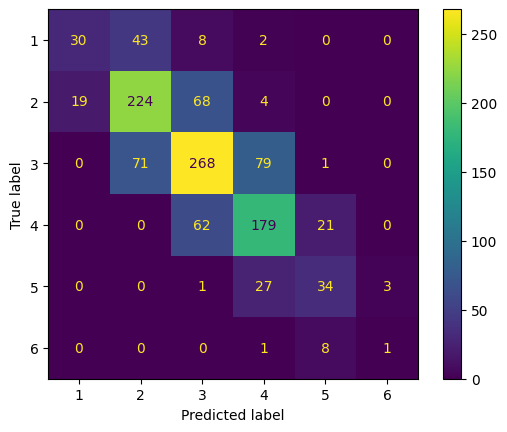

F1 score across fold: 0.6332148977987292
Cohen kappa score across fold: 0.7984508051889713
Mean F1 score across 15 folds: 0.6332148977987292
Mean Cohen kappa score across 15 folds: 0.7984508051889713


In [21]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

i=1
for train_index, test_index in skf.split(X, y_split):
   
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1
    if i==2:
        break

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')



In [22]:
i=0
with open(f"/root/autodl-tmp/socre/output/fold{i}——tfdif_char_wb.txt", "w") as f:
    f.write(f'F1 score across fold: {f1_fold}\n')
    f.write(f'Cohen kappa score across fold: {kappa_fold}\n')
    f.write(f'Mean F1 score across {n_splits} folds: {mean_f1_score}\n')
    f.write(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}\n')

In [15]:
for i in range(6):
    print(f"the presion of label {i+1}:", cm[i][i]/cm.sum(axis = 0)[i])
print("\n\n")
for i in range(6):
    print(f"the reacall of label {i+1}:", cm[i][i]/cm.sum(axis = 1)[i])    
    

the presion of label 1: 0.5927835051546392
the presion of label 2: 0.6344186046511628
the presion of label 3: 0.6600517687661778
the presion of label 4: 0.6317135549872123
the presion of label 5: 0.5127118644067796
the presion of label 6: 0.5625



the reacall of label 1: 0.4581673306772908
the reacall of label 2: 0.722457627118644
the reacall of label 3: 0.6090764331210191
the reacall of label 4: 0.628498727735369
the reacall of label 5: 0.6237113402061856
the reacall of label 6: 0.2903225806451613


* presion : 5的显著降低
* recall： 1，6的很低
* 可以看到，456之间的特征差距有点小，可以着重提取

假如说，我们把这些误分类的情况单独提出来进行预测？会不会也有一定效果？

## 看看train的

In [32]:
X_train_fold.shape, X_test_fold.shape, y_train_fold.shape, y_test_fold.shape, y_test_fold_int.shape

((13845, 21866), (3462, 21866), (13845,), (3462,), (3462,))

In [43]:
y_train_fold_int = y_split[train_index]

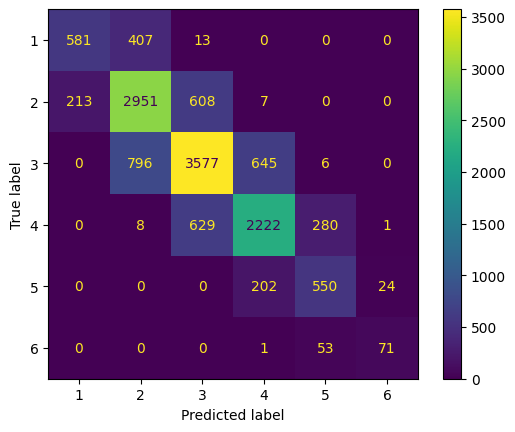

F1 score across fold: 0.7181445369992796
Cohen kappa score across fold: 0.8662963683127937
Mean F1 score across 5 folds: 0.6885267747873284
Mean Cohen kappa score across 5 folds: 0.8469257763137737


In [45]:
predictions_fold = predictor.predict(X_train_fold)
predictions_fold = predictions_fold + a
oof[train_index]=predictions_fold
predictions_fold = predictions_fold.clip(1, 6).round()
predictions.append(predictions_fold)
f1_fold = f1_score(y_train_fold_int, predictions_fold, average='weighted')
f1_scores.append(f1_fold)
kappa_fold = cohen_kappa_score(y_train_fold_int, predictions_fold, weights='quadratic')
kappa_scores.append(kappa_fold)

cm = confusion_matrix(y_train_fold_int, predictions_fold, labels=[x for x in range(1,7)])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(1,7)])
disp.plot()
plt.show()
print(f'F1 score across fold: {f1_fold}')
print(f'Cohen kappa score across fold: {kappa_fold}')
 
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

## K折的

In [ ]:
# n_splits = 15

# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# f1_scores = []
# kappa_scores = []
# models = []
# predictions = []
# callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

# i=1
# for train_index, test_index in skf.split(X, y_split):
   
#     print('fold',i)
#     X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
#     y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
#     model = lgb.LGBMRegressor(
#                 objective = qwk_obj,
#                 metrics = 'None',
#                 learning_rate = 0.1,
#                 max_depth = 5,
#                 num_leaves = 10,
#                 colsample_bytree=0.5,
#                 reg_alpha = 0.1,
#                 reg_lambda = 0.8,
#                 n_estimators=1024,
#                 random_state=42,
#                 extra_trees=True,
#                 class_weight='balanced',
#                 verbosity = - 1)

#     predictor = model.fit(X_train_fold,
#                                   y_train_fold,
#                                   eval_names=['train', 'valid'],
#                                   eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
#                                   eval_metric=quadratic_weighted_kappa,
#                                   callbacks=callbacks,)
#     models.append(predictor)
#     predictions_fold = predictor.predict(X_test_fold)
#     predictions_fold = predictions_fold + a
#     oof[test_index]=predictions_fold
#     predictions_fold = predictions_fold.clip(1, 6).round()
#     predictions.append(predictions_fold)
#     f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
#     f1_scores.append(f1_fold)
    
    
#     kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
#     kappa_scores.append(kappa_fold)
    
#     cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                   display_labels=[x for x in range(1,7)])
#     disp.plot()
#     plt.show()
#     print(f'F1 score across fold: {f1_fold}')
#     print(f'Cohen kappa score across fold: {kappa_fold}')
#     i+=1

# mean_f1_score = np.mean(f1_scores)
# mean_kappa_score = np.mean(kappa_scores)

# print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
# print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')